In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import KFold
import sys
sys.path.append("../code/")

In [6]:
from create_matrix import *

from tensor_custom_core import *
from create_matrix import *
from tensor_custom_core import *
appliance_index = {appliance: APPLIANCES_ORDER.index(appliance) for appliance in APPLIANCES_ORDER}

APPLIANCES = ['fridge', 'hvac', 'wm', 'mw', 'oven', 'dw']
region = "SanDiego"
year = 2014

import os


def un_normalize(x, maximum, minimum):
    return (maximum - minimum) * x + minimum

In [7]:
n_splits = 10
import sys
case=2
a=2
cost='abs'

In [8]:
def get_tensor_appliance(df, dfc, appliance):
    start, stop = 1, 13
    energy_cols = np.array(
        [['%s_%d' % (appliance, month) for month in range(start, stop)] ]).flatten()
    static_cols = ['area', 'total_occupants', 'num_rooms']
    static_df = df[static_cols]
    static_df = static_df.div(static_df.max())
    weather_values = np.array(dds[2014][region][start - 1:stop - 1]).reshape(-1, 1)

    dfc = df.copy()

    df = dfc[energy_cols]
    col_max = df.max().max()
    col_min = df.min().min()
    # df = (1.0 * (df - col_min)) / (col_max - col_min)
    tensor = df.values.reshape((len(df), 1, stop - start))
    M, N, O = tensor.shape
    return tensor

In [16]:
def get_tensor(df):
    start, stop = 1, 13
    energy_cols = np.array(
        [['%s_%d' % (appliance, month) for month in range(start, stop)] for appliance in APPLIANCES_ORDER]).flatten()
    static_cols = ['area', 'total_occupants', 'num_rooms']
    static_df = df[static_cols]
    static_df = static_df.div(static_df.max())

    #dfc = df.copy()

    df = df[energy_cols]
    col_max = df.max().max()
    col_min = df.min().min()
    # df = (1.0 * (df - col_min)) / (col_max - col_min)
    tensor = df.values.reshape((len(df), 7, stop - start))
    M, N, O = tensor.shape
    return tensor

In [17]:
sd_df, sd_dfc = create_matrix_single_region("SanDiego", year)
sd_tensor = get_tensor(sd_df)
au_df, au_dfc = create_matrix_single_region("Austin", year)
au_tensor = get_tensor(au_df)
from sklearn.model_selection import train_test_split, KFold

In [18]:
def find_season_basis(tensor, n_components=2):
        data = tensor.reshape(tensor.shape[0]*7, 12)
        weights = np.ones_like(data)
        weights[np.isnan(data)] = 0
        pca = WPCA(n_components=n_components).fit(data, weights=weights)
        return pca

def find_home_basis(tensor, n_components=2):
    data = np.sum(tensor, axis=2)

    weights = np.ones_like(data)
    weights[np.isnan(data)] = 0
    pca = WPCA(n_components=n_components).fit(data, weights=weights)
    return pca

In [45]:
from wpca import WPCA
s_b = find_season_basis(sd_tensor, 2)
h_b = find_home_basis(sd_tensor, 2)

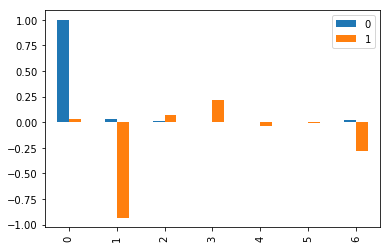

In [46]:
pd.DataFrame(h_b.components_.T).plot(kind='bar')

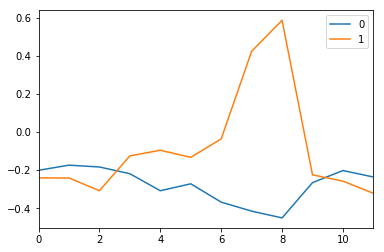

In [47]:
pd.DataFrame(s_b.components_.T).plot()

In [21]:
import autograd.numpy as np
def learning_pca(case, tensor, num_home_f, num_season_f, num_iter=2000, lr=0.1, dis=False, cost_function='abs', random_seed=0, eps=1e-8, lam=0.0):

    def find_season_basis(tensor, n_components=2):
        data = tensor.reshape(tensor.shape[0]*7, 12)
        weights = np.ones_like(data)
        weights[np.isnan(data)] = 0
        pca = WPCA(n_components=n_components).fit(data, weights=weights)
        return pca

    def find_home_basis(tensor, n_components=2):
        data = np.sum(tensor, axis=2)

        weights = np.ones_like(data)
        weights[np.isnan(data)] = 0
        pca = WPCA(n_components=n_components).fit(data, weights=weights)
        return pca


    def cost_abs(H, A, T, eta, tensor, case, lam):
        HAT = multiply_case(H, A, T, case)
        mask = ~np.isnan(tensor)
        error = (HAT - tensor)[mask].flatten()
        error_2 = np.sum(eta-np.sum(A, axis=2))
        
        return np.sqrt((error ** 2).mean()) +lam*error_2
    
   
    
    T = find_season_basis(tensor, num_season_f).components_.T
    eta = find_home_basis(tensor, num_home_f).components_.T
    

    cost = cost_abs
    mg = multigrad(cost, argnums=[0, 1])

    params = {}
    params['M'], params['N'], params['O'] = tensor.shape
    params['a'] = num_home_f
    params['b'] = num_season_f
    H_dim_chars = list(cases[case]['HA'].split(",")[0].strip())
    H_dim = tuple(params[x] for x in H_dim_chars)
    A_dim_chars = list(cases[case]['HA'].split(",")[1].split("-")[0].strip())
    A_dim = tuple(params[x] for x in A_dim_chars)
    T_dim_chars = list(cases[case]['HAT'].split(",")[1].split("-")[0].strip())
    T_dim = tuple(params[x] for x in T_dim_chars)
    print (H_dim, A_dim, T_dim)
    H = np.random.rand(*H_dim)

    A = np.random.rand(*A_dim)
    #return T, eta, H, A

    sum_square_gradients_H = np.zeros_like(H)
    sum_square_gradients_A = np.zeros_like(A)

    Hs = [H.copy()]
    As = [A.copy()]
    costs = [cost(H, A, T, eta, tensor, case, lam)]
    HATs = [multiply_case(H, A, T, 2)]

    # GD procedure
    for i in range(num_iter):
        del_h, del_a = mg(H, A, T, eta, tensor, case, lam)
        sum_square_gradients_H += eps + np.square(del_h)
        sum_square_gradients_A += eps + np.square(del_a)

        lr_h = np.divide(lr, np.sqrt(sum_square_gradients_H))
        lr_a = np.divide(lr, np.sqrt(sum_square_gradients_A))

        H -= lr_h * del_h
        A -= lr_a * del_a
       
        """
        # Projection to non-negative space
        H[H < 0] = 1e-8
        A[A < 0] = 1e-8
        T[T < 0] = 1e-8
        """
     
      
        As.append(A.copy())
        Hs.append(H.copy())
        costs.append(cost(H, A, T, eta, tensor, case, lam))
        HATs.append(multiply_case(H, A, T, 2))
        if i % 100 == 0:
            if dis:
                print(cost(H, A, T, eta, tensor, case, lam))
    return H, A, T, Hs, As, HATs, costs, eta


In [374]:
case = 2
tensor = sd_tensor
num_home_f = 2
num_season_f = 2
lam = 1e-8
#T, eta, H, A = learning_pca(case, tensor, num_home_f, num_season_f, num_iter=1000, lr=1, dis=True, cost_function='abs', random_seed=0, eps=1e-8, lam=lam)
H, A, T, Hs, As, HATs, costs, eta = learning_pca(case, tensor, num_home_f, num_season_f, num_iter=1000, lr=1, dis=True, cost_function='abs', random_seed=0, eps=1e-8, lam=lam)


((39, 2), (7, 2, 2), (12, 2))
216.575133444
85.6431682392
39.437160093
35.1630692716
34.5239571477
34.3064089859
34.2005256793
34.1423346535
34.1095868943
34.0911492948


In [375]:
A

array([[[-34.73356239,  25.97556227],
        [ 34.75820351,  26.98820865]],

       [[-34.26727835,  12.81197431],
        [-14.70722016,   4.7692746 ]],

       [[  0.10429985,  -0.1294473 ],
        [  6.38790892,   1.46162657]],

       [[ -0.25359318,   0.24527912],
        [  0.82267469,   0.61778615]],

       [[ -0.62480317,   0.03677755],
        [  0.38634624,   0.24731164]],

       [[ -0.57841636,  -0.04335712],
        [  0.04962024,   0.11340951]],

       [[ -0.98172353,  -0.33084348],
        [  0.43275064,   0.11478273]]])

In [345]:
eta = find_home_basis(tensor, 3).components_.T

In [365]:
eta

array([[  9.99386756e-01],
       [  2.86014660e-02],
       [  8.77938471e-03],
       [ -5.16523924e-04],
       [ -4.33977142e-04],
       [  9.88419540e-04],
       [  1.81537512e-02]])

In [366]:
A

array([[[ 20.70020897]],

       [[  5.92710848]],

       [[  1.87667604]],

       [[  0.33134004]],

       [[  0.29765626]],

       [[  0.17028657]],

       [[  0.41104989]]])

In [333]:
n_splits = 10
source_df = sd_df
source_dfc = sd_dfc
train_percentage = 10
region="SanDiego"
source = region
num_home_f = 1
num_season_f = 1
random_seed = 0
import datetime

In [334]:
best_params_global = {}
for outer_loop_iteration, (train_max, test) in enumerate(kf.split(source_df)):
    # Just a random thing
    np.random.seed(10 * random_seed + 7 * outer_loop_iteration)
    np.random.shuffle(train_max)
    print("-" * 80)
    print(datetime.datetime.now())
    print("Progress: {}".format(100.0 * outer_loop_iteration / n_splits))
    sys.stdout.flush()
    num_train = int((train_percentage * len(train_max) / 100) + 0.5)
    if train_percentage == 100:
        train = train_max
        train_ix = source_df.index[train]
        # print("Train set {}".format(train_ix.values))
        test_ix = source_df.index[test]
    else:
        train, _ = train_test_split(train_max, train_size=train_percentage / 100.0)
        train_ix = source_df.index[train]
        # print("Train set {}".format(train_ix.values))
        test_ix = source_df.index[test]

    print("-" * 80)

    print("Test set {}".format(test_ix.values))

    print("-" * 80)
    print("Current Error, Least Error, #Iterations")

    ### Inner CV loop to find the optimum set of params. In this case: the number of iterations
    inner_kf = KFold(n_splits=2)
    best_num_iterations = 0
    best_num_season_factors = 0
    best_num_home_factors = 0
    best_appliance_wise_err = {appliance: 1e6 for appliance in APPLIANCES_ORDER[1:]}
    least_error = 1e6

    overall_df_inner = source_df.loc[train_ix]
    best_params_global[outer_loop_iteration] = {}
    for num_iterations_cv in range(100, 1400, 600):
        for num_season_factors_cv in range(2, 5, 2):
            for num_home_factors_cv in range(3, 6, 2):
                pred_inner = {}
                for train_inner, test_inner in inner_kf.split(overall_df_inner):
                    train_ix_inner = overall_df_inner.index[train_inner]
                    test_ix_inner = overall_df_inner.index[test_inner]

                    train_test_ix_inner = np.concatenate([test_ix_inner, train_ix_inner])
                    df_t_inner, dfc_t_inner = source_df.loc[train_test_ix_inner], source_dfc.loc[train_test_ix_inner]
                    tensor_inner = get_tensor(df_t_inner)
                    tensor_copy_inner = tensor_inner.copy()
                    # First n
                    tensor_copy_inner[:len(test_ix_inner), 1:, :] = np.NaN
                    H, A, T, Hs, As, HATs, costs = learning_pca(case, tensor_copy_inner, num_home_factors_cv, 
                                                                num_season_factors_cv, num_iter=num_iterations_cv, lr=1, 
                                                                dis=False, cost_function='abs', random_seed=0,
                                                                eps=1e-8, lam=lam)
                    HAT = multiply_case(H, A, T, case)
                    for appliance in APPLIANCES_ORDER:
                        if appliance not in pred_inner:
                            pred_inner[appliance] = []

                        pred_inner[appliance].append(
                            pd.DataFrame(HAT[:len(test_ix_inner), appliance_index[appliance], :],
                                         index=test_ix_inner))

                err = {}
                appliance_to_weight = []
                for appliance in APPLIANCES_ORDER[1:]:
                    pred_inner[appliance] = pd.DataFrame(pd.concat(pred_inner[appliance]))

                    try:
                        if appliance == "hvac":
                            err[appliance] = \
                                compute_rmse_fraction(appliance, pred_inner[appliance][range(4, 10)], source)[2]
                        else:
                            err[appliance] = compute_rmse_fraction(appliance, pred_inner[appliance], source)[2]
                        appliance_to_weight.append(appliance)
                    except Exception, e:
                        # This appliance does not have enough samples. Will not be
                        # weighed
                        print(e)
                        print(appliance)
                        sys.stdout.flush()
                print("Error weighted on: {}".format(appliance_to_weight))
                print(sys.stdout.flush())
                err_weight = {}
                for appliance in appliance_to_weight:
                    err_weight[appliance] = err[appliance] * contri[source][appliance]
                mean_err = pd.Series(err_weight).sum()
                if mean_err < least_error:
                    best_num_iterations = num_iterations_cv
                    best_num_season_factors = num_season_factors_cv
                    best_num_home_factors = num_home_factors_cv
                    least_error = mean_err
                    best_appliance_wise_err = err
                print(mean_err, least_error, num_iterations_cv, num_home_factors_cv, num_season_factors_cv)
                sys.stdout.flush()
    best_params_global[outer_loop_iteration] = {'Iterations': best_num_iterations,
                                                "Appliance Train Error": best_appliance_wise_err,
                                                'Num season factors': best_num_season_factors,
                                                'Num home factors': best_num_home_factors,
                                                "Least Train Error": least_error}

    print("******* BEST PARAMS *******")
    print(best_params_global[outer_loop_iteration])
    print("******* BEST PARAMS *******")
    sys.stdout.flush()

    num_test = len(test_ix)
    train_test_ix = np.concatenate([test_ix, train_ix])
    df_t, dfc_t = source_df.loc[train_test_ix], source_dfc.loc[train_test_ix]
    tensor = get_tensor(df_t)
    tensor_copy = tensor.copy()
    # First n
    tensor_copy[:num_test, 1:, :] = np.NaN
    H, A, T, Hs, As, HATs, costs = learning_pca(case, tensor_copy, best_num_home_factors, best_num_season_factors, 
                                                num_iter=best_num_iterations, lr=1, dis=False, cost_function='abs', 
                                                random_seed=0, eps=1e-8, lam=lam)
    HAT = multiply_case(H, A, T, case)
    for appliance in APPLIANCES_ORDER:
        pred[appliance].append(pd.DataFrame(HAT[:num_test, appliance_index[appliance], :], index=test_ix))

for appliance in APPLIANCES_ORDER:
    pred[appliance] = pd.DataFrame(pd.concat(pred[appliance]))

--------------------------------------------------------------------------------
2017-08-26 13:06:56.616831
Progress: 0.0
--------------------------------------------------------------------------------
Test set [  54  203  527 1450]
--------------------------------------------------------------------------------
Current Error, Least Error, #Iterations
((39, 3), (7, 3, 2), (12, 2))
((39, 3), (7, 3, 2), (12, 2))
Error weighted on: ['hvac', 'fridge', 'mw', 'dw', 'wm', 'oven']
None
(15.400931907141711, 15.400931907141711, 100, 3, 2)
((39, 5), (7, 5, 2), (12, 2))
((39, 5), (7, 5, 2), (12, 2))
Error weighted on: ['hvac', 'fridge', 'mw', 'dw', 'wm', 'oven']
None
(15.870718640475655, 15.400931907141711, 100, 5, 2)
((39, 3), (7, 3, 4), (12, 4))
((39, 3), (7, 3, 4), (12, 4))
Error weighted on: ['hvac', 'fridge', 'mw', 'dw', 'wm', 'oven']
None
(14.950673506329366, 14.950673506329366, 100, 3, 4)
((39, 5), (7, 5, 4), (12, 4))
((39, 5), (7, 5, 4), (12, 4))
Error weighted on: ['hvac', 'fridge', 'mw'

Error weighted on: ['hvac', 'fridge', 'mw', 'dw', 'wm', 'oven']
None
(12.239906058164397, 10.167217569095552, 1300, 5, 4)
******* BEST PARAMS *******
{'Num season factors': 2, 'Least Train Error': 10.167217569095552, 'Appliance Train Error': {'hvac': 16.380595388511427, 'wm': 0.24451799948743283, 'fridge': 2.5642172996524568, 'mw': 1.8172846942531296, 'oven': 4.1704941063748135, 'dw': 1.0951560981494586}, 'Num home factors': 3, 'Iterations': 700}
******* BEST PARAMS *******
((39, 3), (7, 3, 2), (12, 2))
--------------------------------------------------------------------------------
2017-08-26 13:08:52.075373
Progress: 30.0
--------------------------------------------------------------------------------
Test set [4083 4095 4329 4495]
--------------------------------------------------------------------------------
Current Error, Least Error, #Iterations
((39, 3), (7, 3, 2), (12, 2))
((39, 3), (7, 3, 2), (12, 2))
Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

((39, 3), (7, 3, 2), (12, 2))
((39, 3), (7, 3, 2), (12, 2))
Error weighted on: ['hvac', 'fridge', 'mw', 'dw', 'wm', 'oven']
None
(25.878580067768294, 24.631980608367808, 700, 3, 2)
((39, 5), (7, 5, 2), (12, 2))
((39, 5), (7, 5, 2), (12, 2))
Error weighted on: ['hvac', 'fridge', 'mw', 'dw', 'wm', 'oven']
None
(27.75812650482686, 24.631980608367808, 700, 5, 2)
((39, 3), (7, 3, 4), (12, 4))
((39, 3), (7, 3, 4), (12, 4))
Error weighted on: ['hvac', 'fridge', 'mw', 'dw', 'wm', 'oven']
None
(31.37504628796463, 24.631980608367808, 700, 3, 4)
((39, 5), (7, 5, 4), (12, 4))
((39, 5), (7, 5, 4), (12, 4))
Error weighted on: ['hvac', 'fridge', 'mw', 'dw', 'wm', 'oven']
None
(26.988339458003015, 24.631980608367808, 700, 5, 4)
((39, 3), (7, 3, 2), (12, 2))
((39, 3), (7, 3, 2), (12, 2))
Error weighted on: ['hvac', 'fridge', 'mw', 'dw', 'wm', 'oven']
None
(25.862843957539102, 24.631980608367808, 1300, 3, 2)
((39, 5), (7, 5, 2), (12, 2))
((39, 5), (7, 5, 2), (12, 2))
Error weighted on: ['hvac', 'fridge'

Error weighted on: ['hvac', 'fridge', 'mw', 'dw', 'wm', 'oven']
None
(11.470033503992171, 11.470033503992171, 100, 5, 2)
((39, 3), (7, 3, 4), (12, 4))
((39, 3), (7, 3, 4), (12, 4))
Error weighted on: ['hvac', 'fridge', 'mw', 'dw', 'wm', 'oven']
None
(13.735900860753546, 11.470033503992171, 100, 3, 4)
((39, 5), (7, 5, 4), (12, 4))
((39, 5), (7, 5, 4), (12, 4))
Error weighted on: ['hvac', 'fridge', 'mw', 'dw', 'wm', 'oven']
None
(13.333371603661243, 11.470033503992171, 100, 5, 4)
((39, 3), (7, 3, 2), (12, 2))
((39, 3), (7, 3, 2), (12, 2))
Error weighted on: ['hvac', 'fridge', 'mw', 'dw', 'wm', 'oven']
None
(11.338670797768403, 11.338670797768403, 700, 3, 2)
((39, 5), (7, 5, 2), (12, 2))
((39, 5), (7, 5, 2), (12, 2))
Error weighted on: ['hvac', 'fridge', 'mw', 'dw', 'wm', 'oven']
None
(14.419292070870931, 11.338670797768403, 700, 5, 2)
((39, 3), (7, 3, 4), (12, 4))
((39, 3), (7, 3, 4), (12, 4))
Error weighted on: ['hvac', 'fridge', 'mw', 'dw', 'wm', 'oven']
None
(28.513351614448244, 11.33

TypeError: first argument must be an iterable of pandas objects, you passed an object of type "DataFrame"

In [322]:
kf = KFold(n_splits=n_splits)

pred = {}
for appliance in APPLIANCES_ORDER:
    pred[appliance] = []
for train_max, test in kf.split(source_df):
    print(test)
    num_train = int((train_percentage * len(train_max) / 100) + 0.5)
    if train_percentage == 100:
        train = train_max
    else:
        train, _ = train_test_split(train_max, train_size=train_percentage / 100.0, random_state=random_seed)
    train_ix = source_df.index[train]
    test_ix = source_df.index[test]

    num_test = len(test_ix)
    train_test_ix = np.concatenate([test_ix, train_ix])
    df_t, dfc_t = source_df.loc[train_test_ix], source_dfc.loc[train_test_ix]
    tensor = get_tensor(df_t, dfc_t)
    tensor_copy = tensor.copy()
    # First n
    tensor_copy[:num_test, 1:, :] = np.NaN
    H, A, T, Hs, As, HATs, costs = learning_pca(case, tensor_copy, num_home_f, num_season_f, num_iter=1000, lr=1, dis=False, cost_function='abs', random_seed=0, eps=1e-8, lam=lam)


    HAT = multiply_case(H, A, T, case)
    for appliance in APPLIANCES_ORDER:
        pred[appliance].append(pd.DataFrame(HAT[:num_test, appliance_index[appliance], :], index=test_ix))

for appliance in APPLIANCES_ORDER:
    pred[appliance] = pd.DataFrame(pd.concat(pred[appliance]))

[0 1 2 3]
((7, 1), (7, 1, 1), (12, 1))


/Users/nipunbatra/anaconda2/lib/python2.7/site-packages/wpca/wpca.py:90: RuntimeWarning: invalid value encountered in divide
  self.mean_ = XW.sum(0) / weights.sum(0)


[4 5 6 7]
((7, 1), (7, 1, 1), (12, 1))
[ 8  9 10 11]
((7, 1), (7, 1, 1), (12, 1))
[12 13 14 15]
((7, 1), (7, 1, 1), (12, 1))
[16 17 18 19]
((7, 1), (7, 1, 1), (12, 1))
[20 21 22 23]
((7, 1), (7, 1, 1), (12, 1))
[24 25 26 27]
((7, 1), (7, 1, 1), (12, 1))
[28 29 30 31]
((7, 1), (7, 1, 1), (12, 1))
[32 33 34 35]
((7, 1), (7, 1, 1), (12, 1))
[36 37 38]
((6, 1), (7, 1, 1), (12, 1))


In [335]:
from common import compute_rmse_fraction, contri

In [336]:
o = {}
for appliance in APPLIANCES_ORDER[1:]:
    prediction = pred[appliance]
    if appliance == "hvac":
        prediction = prediction[range(4, 10)]
    o[appliance] = compute_rmse_fraction(appliance, prediction, region)[2]

In [337]:
pd.Series(o)

dw         2.040706
fridge     8.973608
hvac      19.015124
mw         1.884453
oven       2.525775
wm         1.434817
dtype: float64

In [338]:
(pd.Series(o)*pd.Series(contri[region])).sum()

13.634625276595598

In [104]:
from wpca import PCA, WPCA, EMPCA


### Season basis for SD

In [151]:
def find_season_basis(tensor, n_components=2):
    data = tensor.reshape(tensor.shape[0]*7, 12)
    weights = np.ones_like(data)
    weights[np.isnan(data)] = 0
    pca = WPCA(n_components=n_components).fit(data, weights=weights)
    return pca

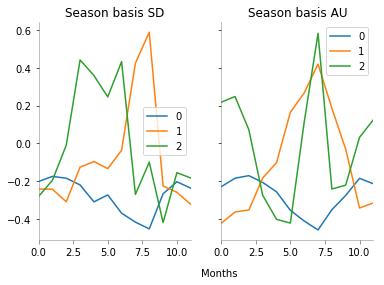

In [168]:
pca_sd = find_season_basis(sd_tensor, 3)
pca_au = find_season_basis(au_tensor, 3)

fig, ax = plt.subplots(ncols=2, sharey=True)
pd.DataFrame(pca_sd.components_).T.plot(ax=ax[0], title="Season basis SD")

pd.DataFrame(pca_au.components_).T.plot(ax=ax[1], title="Season basis AU")
format_axes(ax[0])
format_axes(ax[1])
fig.text(0.5, 0, "Months")

In [246]:
def find_home_basis(tensor, n_components=2):
    data = np.sum(tensor, axis=2)

    weights = np.ones_like(data)
    weights[np.isnan(data)] = 0
    pca = WPCA(n_components=n_components).fit(data, weights=weights)
    return pca

In [173]:
np.nanmean?

In [194]:
pd.DataFrame(np.sum(tensor, axis=2), columns=APPLIANCES_ORDER)

,aggregate,hvac,fridge,mw,dw,wm,oven
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9094.242279,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6646.073395,NaN,475.367405,72.852450,64.634083,NaN,140.907651
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,5786.475800,NaN,NaN,68.622983,26.604316,NaN,122.085066
9,6824.191986,NaN,NaN,91.237117,21.163800,NaN,115.548684


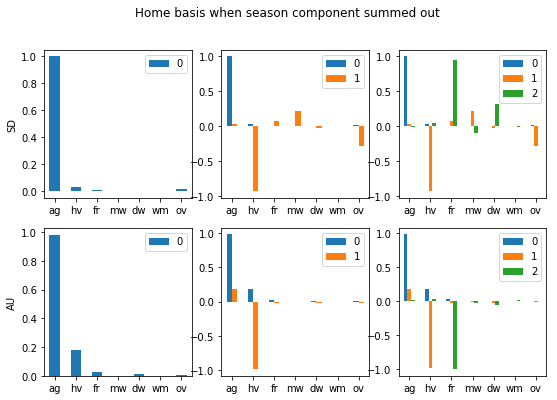

In [195]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(9, 6))

tensors= {'SD':sd_tensor, 'AU':au_tensor}
for row, region in enumerate(['SD','AU']):
    data_region = np.sum(tensors[region], axis=2)

    weights_region = np.ones_like(data_region)
    weights_region[np.isnan(data_region)] = 0
    for col, n_components in enumerate([1, 2, 3]):
        pca_2 = WPCA(n_components=n_components).fit(data_region, weights=weights_region)
        pd.DataFrame(pca_2.components_, columns=[x[:2] for x in APPLIANCES_ORDER]).T.plot(kind='bar', rot=0, ax=ax[row, col])
    ax[row, 0].set_ylabel(region)
plt.suptitle("Home basis when season component summed out")

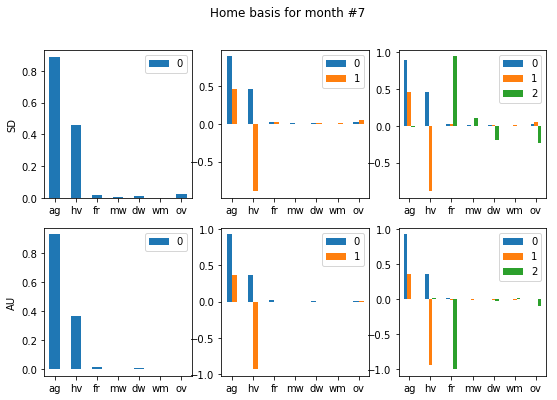

In [199]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(9, 6))

tensors= {'SD':sd_tensor, 'AU':au_tensor}
for row, region in enumerate(['SD','AU']):
    data_region = tensors[region][:,:,7]

    weights_region = np.ones_like(data_region)
    weights_region[np.isnan(data_region)] = 0
    for col, n_components in enumerate([1, 2, 3]):
        pca_2 = WPCA(n_components=n_components).fit(data_region, weights=weights_region)
        pd.DataFrame(pca_2.components_, columns=[x[:2] for x in APPLIANCES_ORDER]).T.plot(kind='bar', rot=0, ax=ax[row, col])
    ax[row, 0].set_ylabel(region)
plt.suptitle("Home basis for month #7")

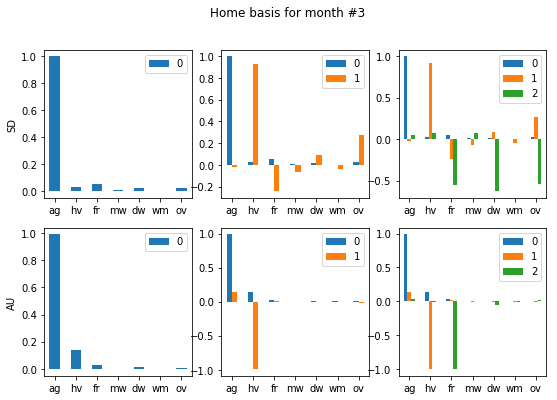

In [198]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(9, 6))

tensors= {'SD':sd_tensor, 'AU':au_tensor}
for row, region in enumerate(['SD','AU']):
    data_region = tensors[region][:,:,3]

    weights_region = np.ones_like(data_region)
    weights_region[np.isnan(data_region)] = 0
    for col, n_components in enumerate([1, 2, 3]):
        pca_2 = WPCA(n_components=n_components).fit(data_region, weights=weights_region)
        pd.DataFrame(pca_2.components_, columns=[x[:2] for x in APPLIANCES_ORDER]).T.plot(kind='bar', rot=0, ax=ax[row, col])
    ax[row, 0].set_ylabel(region)
plt.suptitle("Home basis for month #3")

### Learning

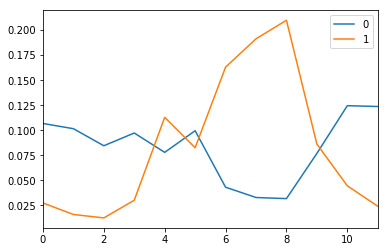

In [83]:
pd.DataFrame(T).plot()

In [34]:
A[5].sum()

0.99999999999999989

1
(216.80763817166198, 0.10000000000000001, 0, 28)
(36.815726277503408, 0.097530930243951111, 500, 25)
(31.804801440211808, 0.095122823542504578, 1000, 25)
(31.505838167832273, 0.092774174675316845, 1500, 26)
(31.395690312624538, 0.090483515586984642, 2000, 25)
(31.260073405787359, 0.088249414469416615, 2500, 25)
(31.105906360416796, 0.086070474866862021, 3000, 26)
(31.064670808249854, 0.083945334803036675, 3500, 25)


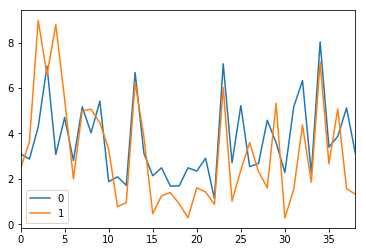

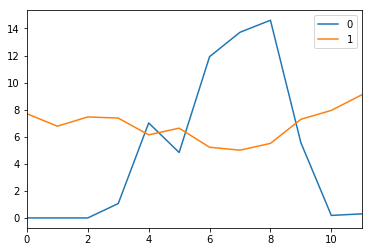

In [39]:
H1, A1, T1 = learn_HAT_new(case, tensor, 2, 2, dis=True, lr=0.1, num_iter=4000, decay_mul=0.99995, lam=1, H_known=None)
pd.DataFrame(H1).plot()
pd.DataFrame(T1).plot()

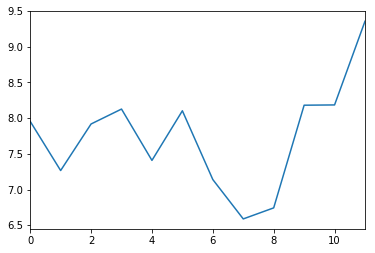

In [64]:
HAT = multiply_case(H1, A1, T1, 2)
pd.DataFrame(HAT[:, 6, :]).mean().plot()

In [23]:
H1, A1, T1 = learn_HAT_new(case, tensor, 10, 10, dis=True, lr=0.1, num_iter=4000, decay_mul=0.99995, lam=1)

1
(211.36775712066967, 0.10000000000000001, 0, 700)
(27.585785060843108, 0.097530930243951111, 500, 419)
(22.248142977658269, 0.095122823542504578, 1000, 400)
(15.420727193069766, 0.092774174675316845, 1500, 367)
(14.340401031583999, 0.090483515586984642, 2000, 568)
(13.701735636551732, 0.088249414469416615, 2500, 578)
(13.212731498111486, 0.086070474866862021, 3000, 585)
(12.828608555053787, 0.083945334803036675, 3500, 590)


In [22]:
H1, A1, T1 = learn_HAT_old(case, tensor, 10, 10, dis=True, lr=0.1, num_iter=2000, decay_mul=0.99995)

(210.87346344509365, 0.10000000000000001, 0, 700)
(26.876927029533967, 0.097530930243951111, 500, 388)
(21.395666967026301, 0.095122823542504578, 1000, 362)
(14.559229720415686, 0.092774174675316845, 1500, 346)


In [205]:
H2, A2, T2 = learn_HAT_new(case, tensor, 10, 10, dis=True, lr=0.1, num_iter=5000, decay_mul=0.999, lam=0.01)

0.01
(210.87840779584073, 0.10000000000000001, 0, 700)
(29.112409949931777, 0.060637894486118477, 500, 411)
(25.868699682243154, 0.036769542477096372, 1000, 369)
(25.065140512433988, 0.022296276370290212, 1500, 368)
(24.097826252832199, 0.013519992539749946, 2000, 379)
(23.083296218205199, 0.0081982388107846599, 2500, 371)
(22.19954384038402, 0.0049712393998036161, 3000, 368)
(21.582297591312017, 0.0030144549019052664, 3500, 363)
(21.184205367361375, 0.0018279019827489415, 4000, 363)
(20.938107091184342, 0.0011084012756089705, 4500, 363)


In [206]:
H2, A2, T2 = learn_HAT_new(case, tensor, 10, 10, dis=True, lr=1, num_iter=5000, decay_mul=0.999, lam=0.0)

0.0
(208.43776626939658, 1.0, 0, 699)
(34.04816640822493, 0.60637894486118471, 500, 700)
(22.544674353625322, 0.36769542477096373, 1000, 695)
(16.455453491879311, 0.22296276370290211, 1500, 698)
(15.638065739866798, 0.13519992539749945, 2000, 652)
(11.616154964271125, 0.081982388107846596, 2500, 569)
(8.0455080189338908, 0.049712393998036161, 3000, 331)
(7.9539584372575858, 0.030144549019052662, 3500, 328)
(7.9070861309352578, 0.018279019827489414, 4000, 327)
(7.8805781082691455, 0.011084012756089705, 4500, 326)


In [207]:
H2, A2, T2 = learn_HAT_new(case, tensor, 10, 10, dis=True, lr=1, num_iter=5000, decay_mul=0.999, lam=0.00001)

1e-05
(208.43777152618921, 1.0, 0, 699)
(34.267204672385922, 0.60637894486118471, 500, 700)
(69.488289822414998, 0.36769542477096373, 1000, 306)
(40.139608476129908, 0.22296276370290211, 1500, 321)
(22.122356422039715, 0.13519992539749945, 2000, 323)
(12.10322317757363, 0.081982388107846596, 2500, 325)
(8.3258463124830051, 0.049712393998036161, 3000, 332)
(8.2667623113825091, 0.030144549019052662, 3500, 326)
(8.2339985155083735, 0.018279019827489414, 4000, 325)
(8.2148480987047385, 0.011084012756089705, 4500, 325)


In [209]:
H2, A2, T2 = learn_HAT(case, tensor, 10, 10, dis=True, lr=1, num_iter=5000, decay_mul=0.999)

(208.43776626939658, 1.0, 0, 699)
(34.04816640822493, 0.60637894486118471, 500, 700)
(22.544674353625322, 0.36769542477096373, 1000, 695)
(16.455453491879311, 0.22296276370290211, 1500, 698)
(15.638065739866798, 0.13519992539749945, 2000, 652)
(11.616154964271125, 0.081982388107846596, 2500, 569)
(8.0455080189338908, 0.049712393998036161, 3000, 331)
(7.9539584372575858, 0.030144549019052662, 3500, 328)
(7.9070861309352578, 0.018279019827489414, 4000, 327)
(7.8805781082691455, 0.011084012756089705, 4500, 326)


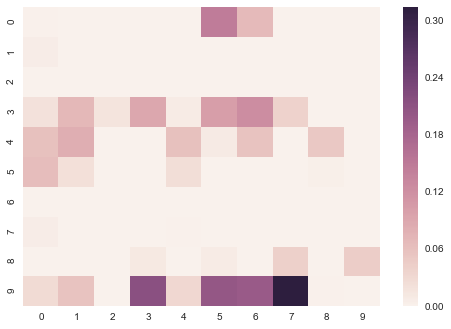

In [208]:
sns.heatmap(A[5])

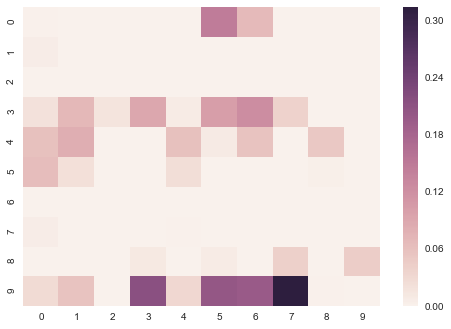

In [149]:
import seaborn as sns
sns.heatmap(A[5])

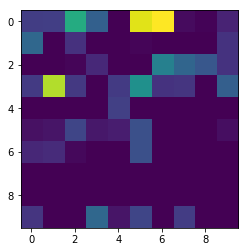

In [143]:
plt.imshow(A[3])

In [135]:
HAT.shape

(39, 7, 12)

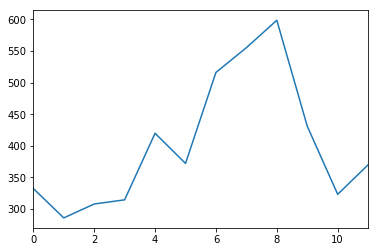

In [136]:
HAT = multiply_case(H, A, T, case)
pd.DataFrame(HAT[:, 0, :]).mean().plot()

In [20]:
pred = {}
sd = {}
out = {}
n_splits = 10
NUM_RANDOM = 4
TRAIN_SPLITS = range(10, 110, 40)
case = 2

cost = 'abs'
for algo in ['adagrad']:
    np.random.seed(0)
    pred[algo] = {}
    for a in range(2, 3):
       
        pred[algo][a] = {}
        for random_seed in range(NUM_RANDOM):
            pred[algo][a][random_seed] = {}
            for appliance in APPLIANCES_ORDER:
                pred[algo][a][random_seed][appliance] = {f:[] for f in TRAIN_SPLITS}

        kf = KFold(n_splits=n_splits)
        for random_seed in range(NUM_RANDOM):

            for train_percentage in TRAIN_SPLITS:
                print(algo, a, random_seed,train_percentage)
                for train_max, test in kf.split(df):

                    num_train = int((train_percentage*len(train_max)/100)+0.5)
                    if train_percentage==100:
                        train = train_max
                    else:
                        train, _ = train_test_split(train_max, train_size = train_percentage/100.0, random_state=random_seed)
                    train_ix = df.index[train]
                    test_ix = df.index[test]

                    num_test = len(test_ix)
                    train_test_ix = np.concatenate([test_ix, train_ix])
                    df_t, dfc_t = df.ix[train_test_ix], dfc.ix[train_test_ix]
                    agg_tensor = get_tensor_appliance(df_t, dfc_t, "aggregate")
                    agg_tensor_copy = agg_tensor.copy()
                    H, A_agg, T = learn_HAT_adagrad(case, agg_tensor, a, a, num_iter=1000, lr=1, dis=False, cost_function=cost)
                    A_appliances = {}
                    for appliance in APPLIANCES_ORDER[1:]:
                        tensor = get_tensor_appliance(df_t, dfc_t, appliance)
                        tensor_copy = tensor.copy()
                        tensor_copy[:num_test, :, :] = np.NaN
                        H, A_appliances[appliance], T = learn_HAT_adagrad(case, tensor, a, a, num_iter=1000, lr=1, dis=False,
                                              cost_function=cost, H_known=H, T_known=T)
    
                        HAT = multiply_case(H, A_appliances[appliance], T, case)
                        pred[algo][a][random_seed][appliance][train_percentage].append(pd.DataFrame(HAT[:num_test, 0, :], index=test_ix))


('adagrad', 2, 0, 10)
('adagrad', 2, 0, 50)
('adagrad', 2, 0, 90)
('adagrad', 2, 1, 10)
('adagrad', 2, 1, 50)
('adagrad', 2, 1, 90)
('adagrad', 2, 2, 10)
('adagrad', 2, 2, 50)
('adagrad', 2, 2, 90)
('adagrad', 2, 3, 10)
('adagrad', 2, 3, 50)
('adagrad', 2, 3, 90)


In [37]:
A_appliances['fridge']

array([[[ 2.0197186 ,  0.        ],
        [ 0.12432689,  0.        ]]])

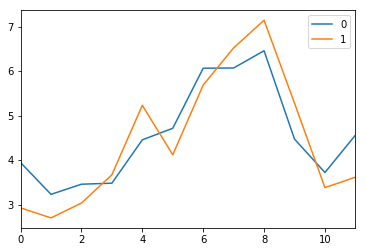

In [40]:
pd.DataFrame(T).plot()

In [25]:
from common import compute_rmse_fraction
out = {}
for algo in ['adagrad']:
    out[algo] = {}
    for a in range(2, 3):
        out[algo][a] = {}
        for random_seed in range(NUM_RANDOM):
            out[algo][a][random_seed] = {}

            for appliance in APPLIANCES_ORDER[1:]:
                out[algo][a][random_seed][appliance] = {}
                for f in TRAIN_SPLITS:
                    s = pd.concat(pred[algo][a][random_seed][appliance][f]).ix[df.index]
                    if appliance=="hvac":
                            out[algo][a][random_seed][appliance][f] = compute_rmse_fraction(appliance,s[range(4, 10)],'SanDiego')[2]
                    else:   
                        out[algo][a][random_seed][appliance][f] = compute_rmse_fraction(appliance, s,'SanDiego')[2]

    

/Users/nipunbatra/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  del sys.path[0]


In [32]:
pd.Panel(out['adagrad'][2]).mean(axis=0)

,dw,fridge,hvac,mw,oven,wm
10,1.810467,6.334669,16.248818,1.737886,2.083915,0.556813
50,1.825415,7.305924,17.177552,1.801521,2.109104,0.599455
90,1.851658,7.821781,19.284749,1.859911,2.186930,0.707624
